In [176]:
import numpy as np
import cv2

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from sklearn.model_selection import train_test_split

from PIL import Image

import tensorflow as tf
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape

from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import  EarlyStopping, ReduceLROnPlateau



# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [177]:
import random
random.seed(0)

### Load data

In [178]:
data = np.load("Part 1- Train data - images.npy",allow_pickle=True)

### Visualization of sample image

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.48, 'y': 0.10385756676557864}, {'x': 0.7716666666666666, 'y': 0.6795252225519288}], 'imageWidth': 600, 'imageHeight': 337}]
0.29166666666666663


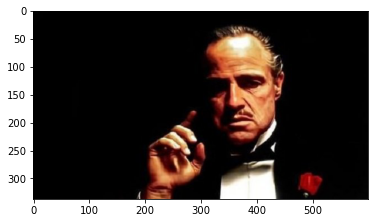

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.22545454545454546, 'y': 0.37142857142857144}, {'x': 0.49454545454545457, 'y': 0.7971428571428572}], 'imageWidth': 275, 'imageHeight': 350}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.4218181818181818, 'y': 0.5228571428571429}, {'x': 0.7527272727272727, 'y': 0.8628571428571429}], 'imageWidth': 275, 'imageHeight': 350}]
0.2690909090909091
0.3309090909090909


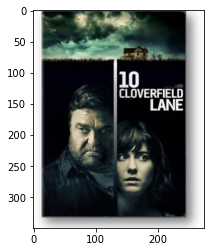

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.29516129032258065, 'y': 0.5163147792706334}, {'x': 0.4290322580645161, 'y': 0.7370441458733206}], 'imageWidth': 620, 'imageHeight': 521}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.7693548387096775, 'y': 0.6890595009596929}, {'x': 0.9, 'y': 0.8483685220729367}], 'imageWidth': 620, 'imageHeight': 521}]
0.13387096774193546
0.13064516129032255


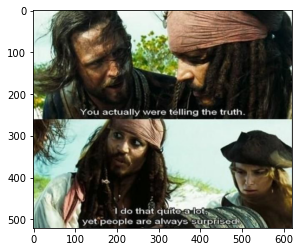

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.4084507042253521, 'y': 0.17341040462427745}, {'x': 0.5644637053087758, 'y': 0.4123314065510597}], 'imageWidth': 1280, 'imageHeight': 720}]
0.15601300108342364


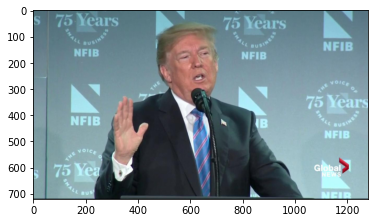

In [179]:
for i in [10,23,44,55]:    
    img,annotation_data = np.array(data[i])
    print(annotation_data)

    boundry_box = []
    for annot in annotation_data:
        imageWidth = annot["imageWidth"]
        imageHeight = annot["imageHeight"]
        print(annot["points"][1]["x"] - annot["points"][0]["x"])
        box_points = [
                     annot["points"][0]["x"]*imageWidth,
                     annot["points"][0]["y"]*imageHeight,
                     (annot["points"][1]["x"] - annot["points"][0]["x"])*imageWidth,
                     (annot["points"][1]["y"] - annot["points"][0]["y"])*imageHeight
                     ]
        boundry_box.append(box_points)

    boundry_box   


    fig, ax = plt.subplots()

    for box in boundry_box:
        # Create a Rectangle patch
        rect = Rectangle((box[0], box[1]), box[2],box[3], linewidth=2, fill=False,color="red")

        # Add the patch to the Axes
        
        

    plt.imshow(img)
    plt.show()

### post processing

In [180]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

In [181]:
y = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))

In [182]:
for index, image_data in enumerate(data):
    img = cv2.resize(image_data[0], dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      print("Error", index)  
      print(img.shape)  
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        y[index][y1:y2, x1:x2] = 1

Error 272
(224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


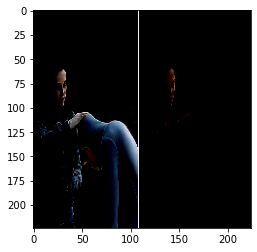

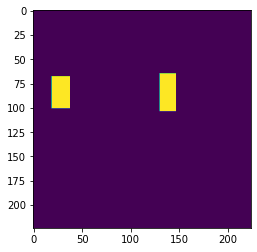

In [183]:

n = 0
plt.imshow(X[n])
plt.show()

plt.imshow(y[n])
plt.show()

### Train , Val Data Split data split 

In [184]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=123)

In [185]:
print("Train Shape - ","X--",X_train.shape," /// y -- ",y_train.shape)
print("Val Shape - ","X--",X_val.shape," /// y -- ",X_val.shape)

Train Shape -  X-- (327, 224, 224, 3)  /// y --  (327, 224, 224)
Val Shape -  X-- (82, 224, 224, 3)  /// y --  (82, 224, 224, 3)


In [186]:
ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

def mobile_net(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")
    for layer in model.layers:
        layer.trainable = trainable

    # Add all the UNET layers here
    block = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block])

    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)

    x = Reshape((IMAGE_HEIGHT, IMAGE_HEIGHT))(x)

    return Model(inputs=model.input, outputs=x)

In [187]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.keras.backend.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

In [192]:
model = mobile_net(False)

#optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

optimizer = SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss=loss, optimizer="sgd", metrics=[dice_coefficient])

# stop = EarlyStopping(monitor="loss", patience=5, mode="min")
# reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")


es = EarlyStopping(monitor='val_loss', patience=10,min_delta=0.01,mode="min")
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=1e-6)

model_history = model.fit(X_train, y_train, epochs=50, batch_size=8,validation_data = (X_val, y_val),verbose=1, callbacks=[ learning_rate_reduction,es])


Epoch 1/50
41/41 [==============================] - 186s 4s/step - loss: 3.3962 - dice_coefficient: 0.3195 - val_loss: 0.9834 - val_dice_coefficient: 0.5563
Epoch 2/50
41/41 [==============================] - 186s 5s/step - loss: 0.8558 - dice_coefficient: 0.5708 - val_loss: 0.8660 - val_dice_coefficient: 0.5901
Epoch 3/50
41/41 [==============================] - 183s 4s/step - loss: 0.7754 - dice_coefficient: 0.6100 - val_loss: 1.1569 - val_dice_coefficient: 0.4845
Epoch 4/50
41/41 [==============================] - 176s 4s/step - loss: 0.7488 - dice_coefficient: 0.6113 - val_loss: 0.7843 - val_dice_coefficient: 0.6120
Epoch 5/50
41/41 [==============================] - 174s 4s/step - loss: 0.7208 - dice_coefficient: 0.6215 - val_loss: 0.8108 - val_dice_coefficient: 0.6029
Epoch 6/50
41/41 [==============================] - 155s 4s/step - loss: 0.7177 - dice_coefficient: 0.6202 - val_loss: 0.7525 - val_dice_coefficient: 0.6226
Epoch 7/50
41/41 [==============================] - 154s 4

### Visualize the prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


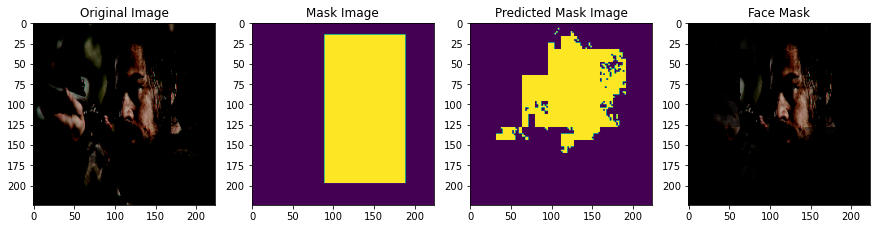

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


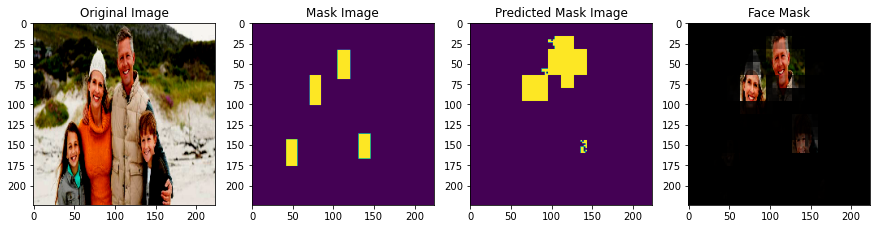

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


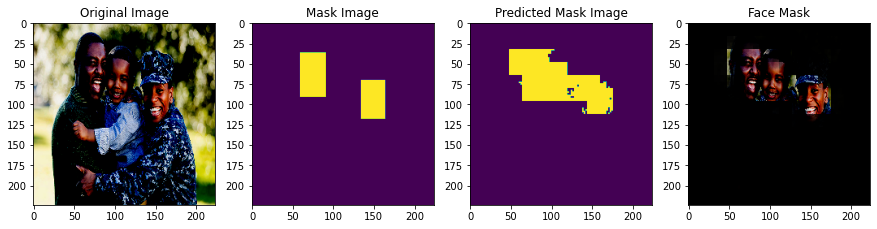

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


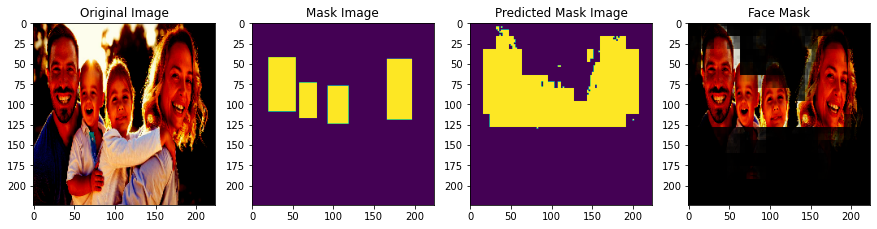

In [197]:
for val_index in [10,12,14,25]:
    plt.figure(figsize=(15,15))
    
    plt.subplot(1,4,1)
    plt.imshow(X_val[val_index])
    plt.title("Original Image")
    
    plt.subplot(1,4,2)
    plt.imshow(y_val[val_index])
    plt.title("Mask Image")
    
    plt.subplot(1,4,3)
    predicted_mask = model.predict(x=np.array([X_val[val_index]]))
    plt.imshow(predicted_mask[0]>0.5)
    plt.title("Predicted Mask Image")
    
    plt.subplot(1,4,4)
    
    masked_img[:,:,0] = predicted_mask*X_val[val_index][:,:,0]
    masked_img[:,:,1] = predicted_mask*X_val[val_index][:,:,1]
    masked_img[:,:,2] = predicted_mask*X_val[val_index][:,:,2]    
    plt.imshow(masked_img)
    plt.title("Face Mask")
    
    plt.show()
    
    

### Test Image Prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


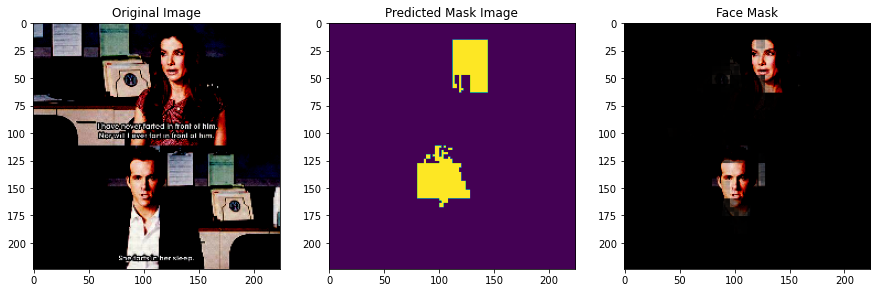

In [195]:
filename = './Part 1Test Data - Prediction Image.jpeg'
test_img = cv2.imread(filename)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img = cv2.resize(test_img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH))
test_img = preprocess_input(np.array(test_img, dtype=np.float32))


plt.figure(figsize=(15,15))
    
plt.subplot(1,3,1)
plt.imshow(test_img)
plt.title("Original Image")


plt.subplot(1,3,2)
predicted_mask = model.predict(x=np.array([test_img]))
plt.imshow(predicted_mask[0]>0.5)
plt.title("Predicted Mask Image")

plt.subplot(1,3,3)

masked_img[:,:,0] = predicted_mask*test_img[:,:,0]
masked_img[:,:,1] = predicted_mask*test_img[:,:,1]
masked_img[:,:,2] = predicted_mask*test_img[:,:,2]    
plt.imshow(masked_img)
plt.title("Face Mask")

plt.show()

### Model Architecture

In [137]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_14[0][0]                   
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
____________________________________________________________________________________________